In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Multi-class Logistic Regression

## Introduction
In this notebook, we'll explore how to extend binary logistic regression to handle multiple classes ($N > 2$). This is a common requirement in many real-world classification problems where we need to classify data into more than two categories.

## From Binary to Multi-class Classification
Binary logistic regression deals with classifying data into two categories. When we have $N > 2$ classes, we need to extend this approach.

### One-against-all Approach
One possibility is to build $N$ one-against-all binary classifiers, each computing the probability that the $n$-th class is present as opposed to any of the other classes. The final label is assigned according to the one-against-all classifier with the highest probability.

While this approach works in practice, it's not very elegant. Let's look at a more principled approach.

## Categorical Distribution Approach
A more elegant way to handle multi-class classification is to describe the posterior probability $P(w|x)$ as a categorical distribution:

$$P(w|x) = \text{Cat}_w[\lambda[x]]$$

where the parameters $\lambda = [\lambda_1, \ldots, \lambda_N]$ are functions of the data $x$. These parameters must satisfy the constraints:
- $\lambda_n \in [0, 1]$ for all $n$
- $\sum_n \lambda_n = 1$

## Model Construction
Similar to binary logistic regression, we'll base our model on linear functions of the data $x$ and pass these through a function that enforces our constraints.

### Step 1: Define Activations
We define $N$ activations (one for each class):

$$a_n = \phi_n^T x$$

where $\phi_1, \ldots, \phi_N$ are parameter vectors. We assume that we have prepended a 1 to each of the data vectors $x_i$ so that the first entry of each parameter vector $\phi_n$ represents an offset.

### Step 2: Apply Softmax Function
The $n$-th entry of the final categorical distribution is defined by the softmax function:

$$\lambda_n = \text{softmax}_n[a_1, a_2, \ldots, a_N] = \frac{\exp[a_n]}{\sum_{m=1}^N \exp[a_m]}$$

The softmax function takes the $N$ activations $a_1, \ldots, a_N$, which can be any real numbers, and maps them to the $N$ parameters $\lambda_1, \ldots, \lambda_N$ of the categorical distribution, ensuring they are positive and sum to one.

## Learning the Parameters
To learn the parameters $\theta = \{\phi_1, \ldots, \phi_N\}$ given training pairs $(w_i, x_i)$, we optimize the log likelihood of the training data:

$$L = \sum_{i=1}^I \log[P(w_i|x_i)]$$

As with binary logistic regression, there is no closed-form expression for the maximum likelihood parameters. However, this is a convex function, and the maximum can be found using nonlinear optimization techniques such as Newton's method.

## Derivatives for Optimization
These optimization techniques require the first and second derivatives of the log likelihood with respect to the parameters. The gradient and Hessian can be derived and used in the optimization process.

## Implementation in Python

```python
import numpy as np
from scipy.optimize import minimize

def softmax(a):
    """Compute softmax values for each set of scores in a."""
    # Shift for numerical stability
    shifted_a = a - np.max(a, axis=1, keepdims=True)
    exp_a = np.exp(shifted_a)
    return exp_a / np.sum(exp_a, axis=1, keepdims=True)

class MulticlassLogisticRegression:
    def __init__(self, n_features, n_classes):
        self.n_features = n_features
        self.n_classes = n_classes
        # Initialize parameters (flattened for optimization)
        self.params = np.zeros((n_features + 1) * n_classes)
        
    def reshape_params(self, params=None):
        """Reshape flat parameter vector to parameter matrix."""
        if params is None:
            params = self.params
        return params.reshape(self.n_classes, self.n_features + 1)
    
    def predict_proba(self, X, params=None):
        """Compute class probabilities for X."""
        # Add bias term
        X_with_bias = np.hstack([np.ones((X.shape[0], 1)), X])
        # Reshape parameters
        phi = self.reshape_params(params)
        # Compute activations
        activations = np.dot(X_with_bias, phi.T)
        # Apply softmax
        return softmax(activations)
    
    def negative_log_likelihood(self, params, X, y):
        """Compute negative log likelihood."""
        probs = self.predict_proba(X, params)
        # Create one-hot encoding of y
        y_one_hot = np.zeros((y.size, self.n_classes))
        y_one_hot[np.arange(y.size), y] = 1
        # Compute log likelihood
        log_likelihood = np.sum(y_one_hot * np.log(probs))
        return -log_likelihood
    
    def fit(self, X, y):
        """Fit the model using ML estimation."""
        result = minimize(
            self.negative_log_likelihood,
            self.params,
            args=(X, y),
            method='BFGS',
            options={'disp': True}
        )
        self.params = result.x
        return self
    
    def predict(self, X):
        """Predict class labels for X."""
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)
```

## Example Usage

```python
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate a synthetic dataset
X, y = make_classification(
    n_samples=1000, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_clusters_per_class=1, 
    n_classes=3, 
    random_state=42
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit multiclass logistic regression
model = MulticlassLogisticRegression(n_features=2, n_classes=3)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Plot decision boundaries
def plot_decision_boundary(X, y, model):
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict class labels for the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8)
    
    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundaries for Multi-class Logistic Regression')
    plt.colorbar()
    plt.show()

plot_decision_boundary(X, y, model)
```

## Conclusion
Multi-class logistic regression extends binary logistic regression to handle multiple classes by using the softmax function to ensure that the output probabilities are valid (positive and sum to one). While the one-against-all approach works, the categorical distribution approach is more elegant and principled.

This model can be optimized using various techniques such as Newton's method or gradient descent, and is a fundamental algorithm in machine learning for multi-class classification problems.

In [3]:
import numpy as np
from scipy.optimize import minimize

def softmax(a):
    """Compute softmax values for each set of scores in a."""
    # Shift for numerical stability
    shifted_a = a - np.max(a, axis=1, keepdims=True)
    exp_a = np.exp(shifted_a)
    return exp_a / np.sum(exp_a, axis=1, keepdims=True)

class MulticlassLogisticRegression:
    def __init__(self, n_features, n_classes):
        self.n_features = n_features
        self.n_classes = n_classes
        # Initialize parameters (flattened for optimization)
        self.params = np.zeros((n_features + 1) * n_classes)
        
    def reshape_params(self, params=None):
        """Reshape flat parameter vector to parameter matrix."""
        if params is None:
            params = self.params
        return params.reshape(self.n_classes, self.n_features + 1)
    
    def predict_proba(self, X, params=None):
        """Compute class probabilities for X."""
        # Add bias term
        X_with_bias = np.hstack([np.ones((X.shape[0], 1)), X])
        # Reshape parameters
        phi = self.reshape_params(params)
        # Compute activations
        activations = np.dot(X_with_bias, phi.T)
        # Apply softmax
        return softmax(activations)
    
    def negative_log_likelihood(self, params, X, y):
        """Compute negative log likelihood."""
        probs = self.predict_proba(X, params)
        # Create one-hot encoding of y
        y_one_hot = np.zeros((y.size, self.n_classes))
        y_one_hot[np.arange(y.size), y] = 1
        # Compute log likelihood
        log_likelihood = np.sum(y_one_hot * np.log(probs))
        return -log_likelihood
    
    def fit(self, X, y):
        """Fit the model using ML estimation."""
        result = minimize(
            self.negative_log_likelihood,
            self.params,
            args=(X, y),
            method='BFGS',
            options={'disp': True}
        )
        self.params = result.x
        return self
    
    def predict(self, X):
        """Predict class labels for X."""
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)


Optimization terminated successfully.
         Current function value: 221.291002
         Iterations: 30
         Function evaluations: 350
         Gradient evaluations: 35
Accuracy: 0.8733


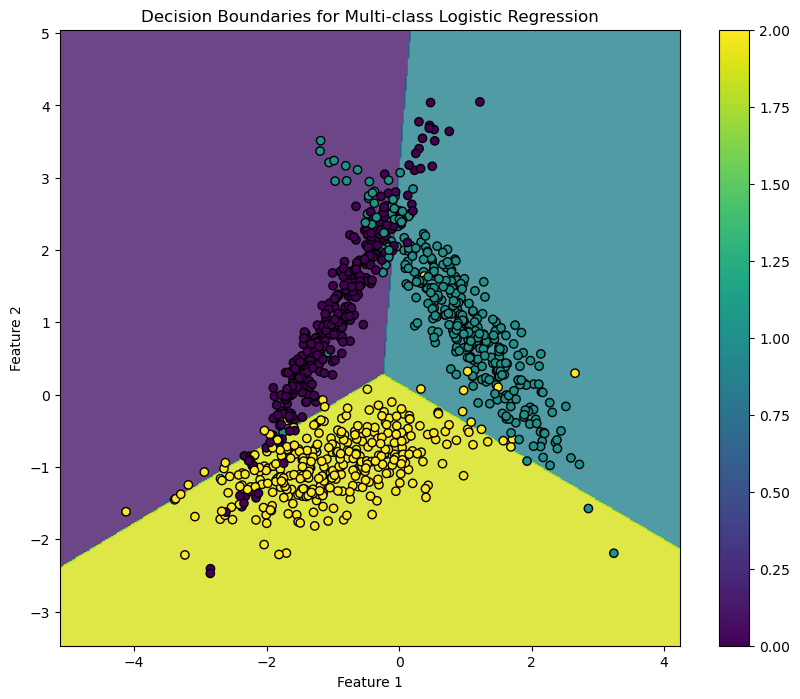

In [4]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate a synthetic dataset
X, y = make_classification(
    n_samples=1000, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_clusters_per_class=1, 
    n_classes=3, 
    random_state=42
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit multiclass logistic regression
model = MulticlassLogisticRegression(n_features=2, n_classes=3)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Plot decision boundaries
def plot_decision_boundary(X, y, model):
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict class labels for the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8)
    
    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundaries for Multi-class Logistic Regression')
    plt.colorbar()
    plt.show()

plot_decision_boundary(X, y, model)

# Multi-class Logistic Regression and Random Forests

## Softmax Function and Probability Distribution

### The Softmax Function
The softmax function is crucial for multi-class logistic regression as it transforms real-valued activations into a valid probability distribution. Let's explore how this works.

![image.png](attachment:image.png)
Fig.19 Multi-class logistic regression. a) We form one activation for each class based on linear functions of the data. b) We pass these activations through the softmax function to create the distribution P r(w|x) which is shown here as a function of x. The softmax function takes the three real- valued activations and returns three positive values that sum to one, ensuring that the distribution P r(w|x) is a valid probability distribution for all x.



*Fig.19: Multi-class logistic regression. a) We form one activation for each class based on linear functions of the data. b) We pass these activations through the softmax function to create the distribution $P(w|x)$ which is shown here as a function of $x$. The softmax function takes the three real-valued activations and returns three positive values that sum to one, ensuring that the distribution $P(w|x)$ is a valid probability distribution for all $x$.*

For each data point $x$, we compute activations $a_n = \phi_n^T x$ for each class $n$. These activations can take any real value, as shown in part (a) of the figure above. The softmax function then transforms these activations into probabilities:

$$\lambda_n = \text{softmax}_n[a_1, a_2, \ldots, a_N] = \frac{\exp[a_n]}{\sum_{m=1}^N \exp[a_m]}$$

This ensures that:
1. All probabilities are positive (due to the exponential function)
2. They sum to 1 (due to the normalization in the denominator)

## Derivatives for Optimization

When optimizing the log-likelihood function for multi-class logistic regression, we need the derivatives with respect to the parameters. The first and second derivatives are:

$$\frac{\partial L}{\partial \phi_n} = -\sum_{i=1}^I (y_{in} - \delta[w_i - n])x_i$$

$$\frac{\partial^2 L}{\partial \phi_m \partial \phi_n} = -\sum_{i=1}^I y_{im} (\delta[m - n] - y_{in})x_i x_i^T$$

where we define:

$$y_{in} = P(w_i = n|x_i) = \text{softmax}_n [a_{i1}, a_{i2}, \ldots, a_{iN}]$$

And $\delta[w_i - n]$ is the Kronecker delta function, which equals 1 when $w_i = n$ and 0 otherwise.

## Implementation of the Derivatives

```python
def gradient(X, y, params, n_classes, n_features):
    """
    Compute the gradient of the log-likelihood function.
    
    Parameters:
    - X: Training data (with bias term already added)
    - y: True class labels
    - params: Current model parameters (flattened)
    - n_classes: Number of classes
    - n_features: Number of features (including bias)
    
    Returns:
    - Gradient of the log-likelihood with respect to parameters
    """
    m = X.shape[0]  # Number of training examples
    
    # Reshape params
    phi = params.reshape(n_classes, n_features)
    
    # Compute softmax predictions
    activations = X @ phi.T  # Shape: (m, n_classes)
    softmax_probs = softmax(activations)  # Shape: (m, n_classes)
    
    # Create one-hot encoding for y
    y_one_hot = np.zeros((m, n_classes))
    y_one_hot[np.arange(m), y] = 1
    
    # Compute the difference (y_in - δ[w_i - n])
    diff = softmax_probs - y_one_hot  # Shape: (m, n_classes)
    
    # Compute gradient for each class
    grad = np.zeros((n_classes, n_features))
    for n in range(n_classes):
        grad[n] = (diff[:, n].reshape(-1, 1) * X).sum(axis=0)
    
    return grad.flatten()
```

## Extensions of Multi-class Logistic Regression

Multi-class logistic regression can be extended in several ways, similar to the binary case:

1. **Bayesian approach**: Incorporate prior distributions over parameters
2. **Nonlinear extensions**: Use nonlinear feature transformations
3. **Dual formulation**: Express the problem in terms of inner products
4. **Kernelized version**: Apply kernel functions for implicit feature space transformations
5. **Incremental training**: Update parameters as new data arrives
6. **Boosting**: Combine weak classifiers to create a strong classifier

## Tree-Structured Models: Random Trees, Forests, and Ferns

### Introduction to Tree-Based Methods

Tree-structured models have become extremely popular for multi-class problems in computer vision and other applications. These methods create a binary tree where at each node, the data is evaluated to determine whether it will pass to the left or right child node.

### Random Classification Trees

The key idea in random classification trees is to construct a binary decision tree where:

1. Each non-leaf node contains a test function that routes data to either left or right child
2. Each leaf node contains a class probability distribution

The routing process happens recursively, and the data point becomes progressively more specialized as it moves down the tree.

```python
class RandomTreeNode:
    def __init__(self, depth=0, max_depth=10):
        self.depth = depth
        self.max_depth = max_depth
        self.left = None
        self.right = None
        self.feature_idx = None
        self.threshold = None
        self.class_distribution = None
        
    def is_leaf(self):
        return self.left is None and self.right is None
    
    def split_node(self, X, y, n_classes):
        # If we've reached maximum depth or have few samples, make a leaf
        if self.depth >= self.max_depth or len(y) <= 5:
            self.class_distribution = np.bincount(y, minlength=n_classes) / len(y)
            return
        
        # Choose a random feature and threshold
        n_features = X.shape[1]
        self.feature_idx = np.random.randint(0, n_features)
        feature_values = X[:, self.feature_idx]
        self.threshold = np.random.uniform(feature_values.min(), feature_values.max())
        
        # Split data
        left_indices = X[:, self.feature_idx] <= self.threshold
        right_indices = ~left_indices
        
        # If the split doesn't separate samples, make a leaf
        if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
            self.class_distribution = np.bincount(y, minlength=n_classes) / len(y)
            return
        
        # Create children nodes
        self.left = RandomTreeNode(depth=self.depth+1, max_depth=self.max_depth)
        self.right = RandomTreeNode(depth=self.depth+1, max_depth=self.max_depth)
        
        # Recursively split children
        self.left.split_node(X[left_indices], y[left_indices], n_classes)
        self.right.split_node(X[right_indices], y[right_indices], n_classes)
    
    def predict_proba(self, x):
        if self.is_leaf():
            return self.class_distribution
        
        if x[self.feature_idx] <= self.threshold:
            return self.left.predict_proba(x)
        else:
            return self.right.predict_proba(x)
```

### Random Forests

Random forests extend the concept of random trees by training multiple trees and combining their predictions. This ensemble approach typically provides better generalization performance than a single tree.

The key principles of random forests are:

1. **Bagging (Bootstrap Aggregating)**: Each tree is trained on a random subset of the training data
2. **Feature Randomness**: At each node, only a random subset of features is considered for splitting
3. **Ensemble Decision**: The final prediction is based on majority voting or averaging probabilities

```python
class RandomForest:
    def __init__(self, n_trees=100, max_depth=10):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []
        self.n_classes = None
        
    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        
        for _ in range(self.n_trees):
            # Bootstrap sampling
            indices = np.random.choice(len(y), size=len(y), replace=True)
            X_bootstrap, y_bootstrap = X[indices], y[indices]
            
            # Train a new tree
            root = RandomTreeNode(max_depth=self.max_depth)
            root.split_node(X_bootstrap, y_bootstrap, self.n_classes)
            self.trees.append(root)
        
        return self
    
    def predict_proba(self, X):
        predictions = np.zeros((X.shape[0], self.n_classes))
        
        for i, x in enumerate(X):
            tree_predictions = np.array([tree.predict_proba(x) for tree in self.trees])
            predictions[i] = np.mean(tree_predictions, axis=0)
            
        return predictions
    
    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)
```

### Random Ferns

Random ferns are a simplified variant of random forests. They use a non-hierarchical structure where each fern consists of a set of binary tests (feature comparisons). The results of these tests are combined to index into a table of class probabilities.

Random ferns are computationally efficient and have been successfully applied to tasks like object detection and recognition.

## Conclusion

Multi-class logistic regression and tree-based methods like random forests are powerful tools for classification problems in machine learning and computer vision. The softmax function plays a crucial role in multi-class logistic regression by ensuring valid probability distributions.

Random trees and forests provide a different approach to classification that can capture complex decision boundaries and are particularly effective for multi-class problems. Their ability to handle high-dimensional data and their robustness to noise make them popular choices in many applications.

MULTI-CLASS LOGISTIC REGRESSION DEMO
Iteration 100/1000, Loss: 0.425202
Iteration 200/1000, Loss: 0.393627
Converged at iteration 224

Test Accuracy: 0.8733

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       101
           1       0.87      0.86      0.87        87
           2       0.90      0.92      0.91       112

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300



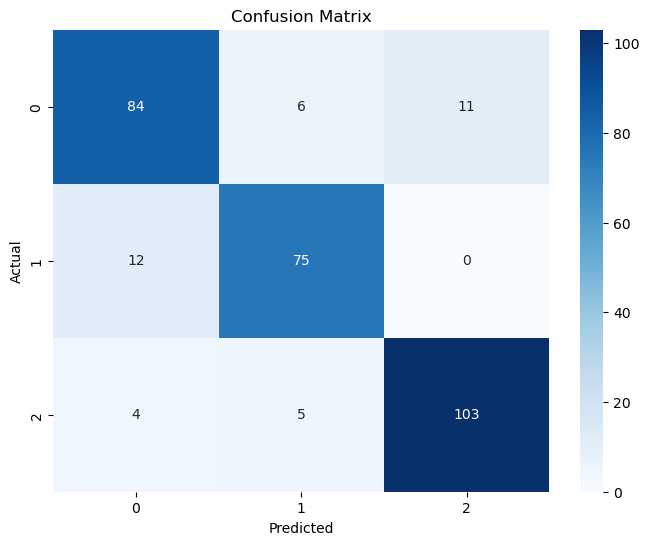

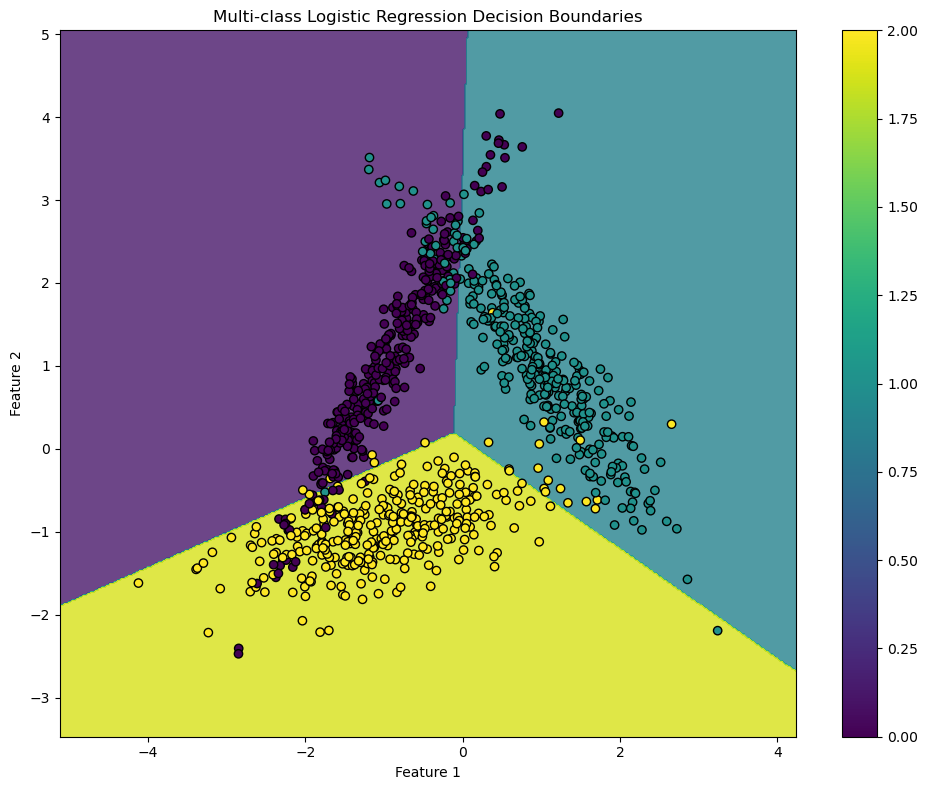

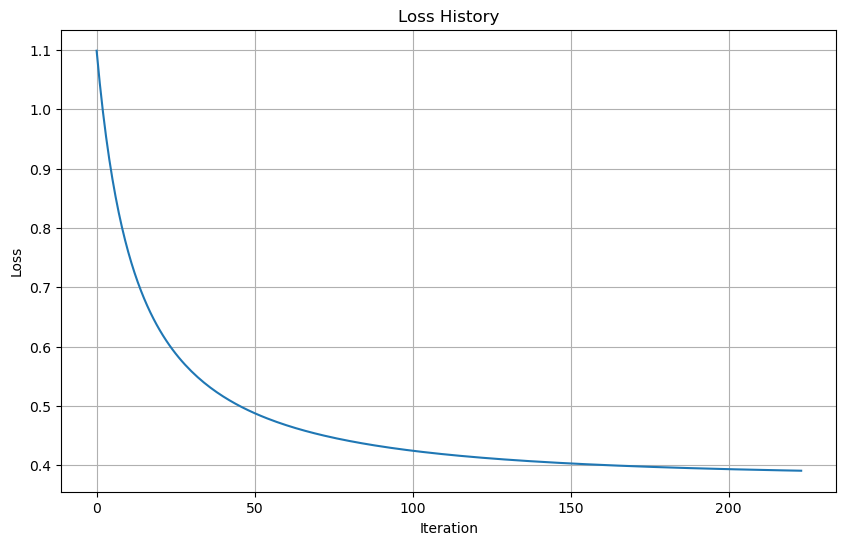

RANDOM FOREST DEMO
Training tree 10/50
Training tree 20/50
Training tree 30/50
Training tree 40/50
Training tree 50/50

Test Accuracy: 0.8633

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        90
           1       0.86      0.85      0.86        96
           2       0.88      0.82      0.85       114

    accuracy                           0.86       300
   macro avg       0.86      0.87      0.86       300
weighted avg       0.86      0.86      0.86       300



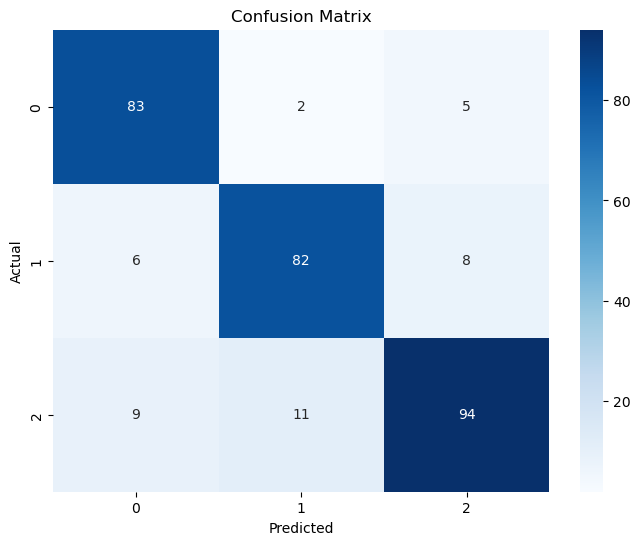

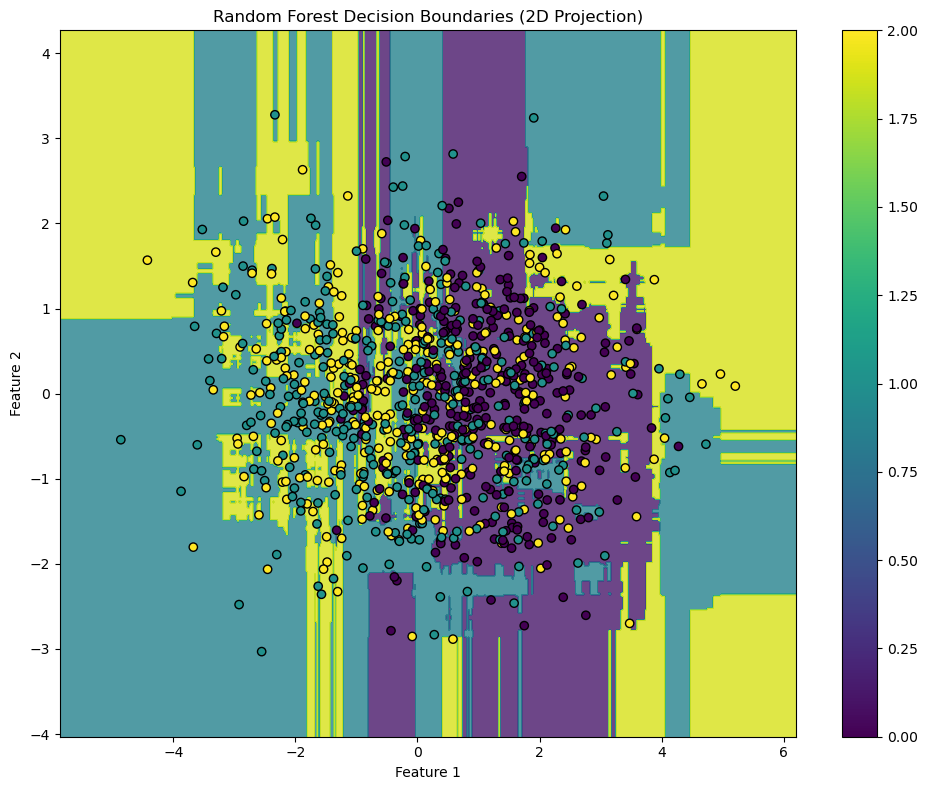

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


################################################################################
# Multi-class Logistic Regression Implementation
################################################################################

class MulticlassLogisticRegression:
    def __init__(self, learning_rate=0.01, max_iterations=1000, tol=1e-4, 
                 reg_lambda=0.01, verbose=True):
        """
        Initialize the multi-class logistic regression model.
        
        Parameters:
        -----------
        learning_rate : float
            The step size for gradient descent
        max_iterations : int
            Maximum number of iterations for optimization
        tol : float
            Convergence threshold for log-likelihood change
        reg_lambda : float
            L2 regularization strength
        verbose : bool
            Whether to print progress information
        """
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tol = tol
        self.reg_lambda = reg_lambda
        self.verbose = verbose
        self.weights = None
        self.classes = None
        self.n_classes = None
        self.n_features = None
        self.loss_history = []
    
    def _add_bias(self, X):
        """Add a bias term (column of 1s) to the input data."""
        return np.hstack([np.ones((X.shape[0], 1)), X])
    
    def _softmax(self, z):
        """
        Compute softmax function safely to avoid numerical overflow.
        
        Parameters:
        -----------
        z : ndarray, shape (n_samples, n_classes)
            Linear activations
            
        Returns:
        --------
        ndarray, shape (n_samples, n_classes)
            Softmax probabilities
        """
        # Shift for numerical stability (subtract max from each row)
        shifted_z = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(shifted_z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def _compute_loss(self, y_true, y_pred):
        """
        Compute cross-entropy loss with L2 regularization.
        
        Parameters:
        -----------
        y_true : ndarray, shape (n_samples, n_classes)
            One-hot encoded true labels
        y_pred : ndarray, shape (n_samples, n_classes)
            Predicted probabilities
            
        Returns:
        --------
        float
            Cross-entropy loss with regularization
        """
        # Small constant to avoid log(0)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # Cross-entropy loss
        cross_entropy = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
        
        # L2 regularization term (excluding bias term)
        l2_reg = 0.5 * self.reg_lambda * np.sum(self.weights[:, 1:] ** 2)
        
        return cross_entropy + l2_reg
    
    def _gradient(self, X, y_true, y_pred):
        """
        Compute the gradient of the loss function.
        
        Parameters:
        -----------
        X : ndarray, shape (n_samples, n_features + 1)
            Input data with bias term
        y_true : ndarray, shape (n_samples, n_classes)
            One-hot encoded true labels
        y_pred : ndarray, shape (n_samples, n_classes)
            Predicted probabilities
            
        Returns:
        --------
        ndarray, shape (n_classes, n_features + 1)
            Gradient of the loss function
        """
        # Basic gradient of cross-entropy
        error = y_pred - y_true  # shape: (n_samples, n_classes)
        grad = np.dot(error.T, X) / X.shape[0]  # shape: (n_classes, n_features + 1)
        
        # Add L2 regularization gradient (exclude bias term)
        grad_reg = np.copy(grad)
        grad_reg[:, 1:] += self.reg_lambda * self.weights[:, 1:]
        
        return grad_reg
    
    def fit(self, X, y):
        """
        Fit the multi-class logistic regression model.
        
        Parameters:
        -----------
        X : ndarray, shape (n_samples, n_features)
            Training data
        y : ndarray, shape (n_samples,)
            Target labels
            
        Returns:
        --------
        self : object
            Returns self
        """
        # Get unique classes and their number
        self.classes = np.unique(y)
        self.n_classes = len(self.classes)
        self.n_features = X.shape[1]
        
        # Add bias term to X
        X_with_bias = self._add_bias(X)
        
        # Initialize weights
        self.weights = np.zeros((self.n_classes, X_with_bias.shape[1]))
        
        # Convert y to one-hot encoding
        y_one_hot = np.zeros((y.size, self.n_classes))
        for i, c in enumerate(self.classes):
            y_one_hot[:, i] = (y == c).astype(int)
        
        # Gradient descent
        prev_loss = float('inf')
        self.loss_history = []
        
        for iteration in range(self.max_iterations):
            # Forward pass: compute probabilities
            activations = np.dot(X_with_bias, self.weights.T)  # shape: (n_samples, n_classes)
            y_pred = self._softmax(activations)
            
            # Compute loss
            current_loss = self._compute_loss(y_one_hot, y_pred)
            self.loss_history.append(current_loss)
            
            # Check for convergence
            if abs(prev_loss - current_loss) < self.tol:
                if self.verbose:
                    print(f"Converged at iteration {iteration+1}")
                break
            
            # Compute gradient
            grad = self._gradient(X_with_bias, y_one_hot, y_pred)
            
            # Update weights using gradient descent
            self.weights -= self.learning_rate * grad
            
            # Update previous loss
            prev_loss = current_loss
            
            # Print progress if verbose
            if self.verbose and (iteration + 1) % 100 == 0:
                print(f"Iteration {iteration+1}/{self.max_iterations}, Loss: {current_loss:.6f}")
        
        return self
    
    def predict_proba(self, X):
        """
        Predict class probabilities.
        
        Parameters:
        -----------
        X : ndarray, shape (n_samples, n_features)
            Test data
            
        Returns:
        --------
        ndarray, shape (n_samples, n_classes)
            Class probabilities
        """
        X_with_bias = self._add_bias(X)
        activations = np.dot(X_with_bias, self.weights.T)
        return self._softmax(activations)
    
    def predict(self, X):
        """
        Predict class labels.
        
        Parameters:
        -----------
        X : ndarray, shape (n_samples, n_features)
            Test data
            
        Returns:
        --------
        ndarray, shape (n_samples,)
            Predicted class labels
        """
        probas = self.predict_proba(X)
        return self.classes[np.argmax(probas, axis=1)]
    
    def plot_decision_boundary(self, X, y, title="Decision Boundaries"):
        """
        Plot the decision boundaries for 2D data.
        
        Parameters:
        -----------
        X : ndarray, shape (n_samples, 2)
            2D data points
        y : ndarray, shape (n_samples,)
            True class labels
        title : str
            Plot title
        """
        if X.shape[1] != 2:
            raise ValueError("This method is only for 2D data (for visualization)")
        
        # Create a mesh grid to visualize decision boundaries
        h = 0.02  # step size in the mesh
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        
        # Predict class for each point in the mesh
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Create a color map
        cmap = plt.cm.RdYlBu if self.n_classes <= 2 else plt.cm.viridis
        
        # Plot the decision boundary
        plt.figure(figsize=(10, 8))
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=cmap)
        
        # Plot the data points
        scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=cmap)
        plt.colorbar(scatter)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title(title)
        plt.tight_layout()
        plt.show()
    
    def plot_loss_history(self):
        """Plot the loss history during training."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_history)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Loss History')
        plt.grid(True)
        plt.show()


################################################################################
# Random Tree and Random Forest Implementation
################################################################################

class RandomTreeNode:
    def __init__(self, depth=0, max_depth=10, min_samples_split=2, 
                 max_features=None, random_state=None):
        """
        Initialize a node in a random decision tree.
        
        Parameters:
        -----------
        depth : int
            Current depth of the node in the tree
        max_depth : int
            Maximum depth of the tree
        min_samples_split : int
            Minimum number of samples required to split a node
        max_features : int or None
            Maximum number of features to consider for the best split
        random_state : int or None
            Random seed for reproducibility
        """
        self.depth = depth
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.feature_idx = None
        self.threshold = None
        self.left = None
        self.right = None
        self.class_distribution = None
        self.rng = np.random.RandomState(random_state)
        
    def is_leaf(self):
        """Check if the node is a leaf node."""
        return self.left is None and self.right is None
    
    def _gini_impurity(self, y):
        """
        Calculate the Gini impurity for a set of labels.
        
        Parameters:
        -----------
        y : ndarray
            Class labels
            
        Returns:
        --------
        float
            Gini impurity
        """
        m = len(y)
        if m == 0:
            return 0
        
        # Count frequencies of each class
        _, counts = np.unique(y, return_counts=True)
        proportions = counts / m
        
        # Gini impurity formula: 1 - sum(p_i^2)
        return 1 - np.sum(proportions ** 2)
    
    def _information_gain(self, y, y_left, y_right):
        """
        Calculate the information gain from a split.
        
        Parameters:
        -----------
        y : ndarray
            Parent class labels
        y_left : ndarray
            Left child class labels
        y_right : ndarray
            Right child class labels
            
        Returns:
        --------
        float
            Information gain
        """
        m = len(y)
        m_left = len(y_left)
        m_right = len(y_right)
        
        if m == 0 or m_left == 0 or m_right == 0:
            return 0
        
        # Calculate weighted average of child impurities
        weighted_child_impurity = (m_left / m) * self._gini_impurity(y_left) + \
                                  (m_right / m) * self._gini_impurity(y_right)
        
        # Information gain is the difference between parent impurity and weighted child impurity
        return self._gini_impurity(y) - weighted_child_impurity
    
    def _find_best_split(self, X, y):
        """
        Find the best feature and threshold to split the data.
        
        Parameters:
        -----------
        X : ndarray, shape (n_samples, n_features)
            Feature matrix
        y : ndarray, shape (n_samples,)
            Target labels
            
        Returns:
        --------
        tuple
            (best_feature_idx, best_threshold, best_info_gain)
        """
        m, n = X.shape
        
        # If max_features is specified, randomly select features
        if self.max_features is not None:
            n_features = min(self.max_features, n)
            feature_indices = self.rng.choice(n, size=n_features, replace=False)
        else:
            feature_indices = range(n)
        
        best_info_gain = -float('inf')
        best_feature_idx = None
        best_threshold = None
        
        # Try each feature
        for feature_idx in feature_indices:
            # Get unique values for the feature
            feature_values = np.unique(X[:, feature_idx])
            
            # Try different thresholds
            for i in range(len(feature_values) - 1):
                threshold = (feature_values[i] + feature_values[i+1]) / 2
                
                # Split based on the threshold
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                
                # Skip if the split doesn't separate samples
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                # Calculate information gain
                info_gain = self._information_gain(y, y[left_mask], y[right_mask])
                
                # Update best split if this is better
                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_feature_idx = feature_idx
                    best_threshold = threshold
        
        return best_feature_idx, best_threshold, best_info_gain
    
    def fit(self, X, y, n_classes):
        """
        Build the decision tree by recursively splitting nodes.
        
        Parameters:
        -----------
        X : ndarray, shape (n_samples, n_features)
            Feature matrix
        y : ndarray, shape (n_samples,)
            Target labels
        n_classes : int
            Number of classes
        """
        m = len(y)
        
        # Check if this should be a leaf node
        if (self.depth >= self.max_depth or 
            m <= self.min_samples_split or 
            len(np.unique(y)) == 1):
            # Create class distribution at this leaf
            self.class_distribution = np.bincount(y, minlength=n_classes) / m
            return
        
        # Find the best split
        self.feature_idx, self.threshold, info_gain = self._find_best_split(X, y)
        
        # If no good split was found, make this a leaf
        if self.feature_idx is None or info_gain <= 0:
            self.class_distribution = np.bincount(y, minlength=n_classes) / m
            return
        
        # Split the data
        left_mask = X[:, self.feature_idx] <= self.threshold
        right_mask = ~left_mask
        
        # Create child nodes
        self.left = RandomTreeNode(
            depth=self.depth+1, 
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            max_features=self.max_features,
            random_state=self.rng.randint(0, 2**31-1)
        )
        
        self.right = RandomTreeNode(
            depth=self.depth+1, 
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            max_features=self.max_features,
            random_state=self.rng.randint(0, 2**31-1)
        )
        
        # Recursively fit child nodes
        self.left.fit(X[left_mask], y[left_mask], n_classes)
        self.right.fit(X[right_mask], y[right_mask], n_classes)
    
    def predict_proba(self, x):
        """
        Predict class probabilities for a single sample.
        
        Parameters:
        -----------
        x : ndarray, shape (n_features,)
            Feature vector
            
        Returns:
        --------
        ndarray, shape (n_classes,)
            Class probabilities
        """
        if self.is_leaf():
            return self.class_distribution
        
        if x[self.feature_idx] <= self.threshold:
            return self.left.predict_proba(x)
        else:
            return self.right.predict_proba(x)


class RandomForest:
    def __init__(self, n_estimators=100, max_depth=10, min_samples_split=2, 
                 max_features='sqrt', bootstrap=True, random_state=None, verbose=False):
        """
        Random Forest classifier.
        
        Parameters:
        -----------
        n_estimators : int
            Number of trees in the forest
        max_depth : int
            Maximum depth of each tree
        min_samples_split : int
            Minimum number of samples required to split a node
        max_features : int, float, str or None
            Number of features to consider for each split
            - If int, consider max_features features
            - If float, consider max_features * n_features features
            - If 'sqrt', consider sqrt(n_features) features
            - If 'log2', consider log2(n_features) features
            - If None, consider all features
        bootstrap : bool
            Whether to use bootstrap sampling
        random_state : int or None
            Random seed for reproducibility
        verbose : bool
            Whether to print progress information
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.verbose = verbose
        self.trees = []
        self.n_classes = None
        self.classes = None
        self.rng = np.random.RandomState(random_state)
    
    def _get_max_features(self, n_features):
        """
        Determine the number of features to consider for splitting.
        
        Parameters:
        -----------
        n_features : int
            Total number of features
            
        Returns:
        --------
        int
            Number of features to consider
        """
        if self.max_features is None:
            return n_features
        elif isinstance(self.max_features, int):
            return min(self.max_features, n_features)
        elif isinstance(self.max_features, float):
            return max(1, int(self.max_features * n_features))
        elif self.max_features == 'sqrt':
            return max(1, int(np.sqrt(n_features)))
        elif self.max_features == 'log2':
            return max(1, int(np.log2(n_features)))
        else:
            raise ValueError(f"Invalid max_features: {self.max_features}")
    
    def fit(self, X, y):
        """
        Build the random forest.
        
        Parameters:
        -----------
        X : ndarray, shape (n_samples, n_features)
            Training data
        y : ndarray, shape (n_samples,)
            Target labels
            
        Returns:
        --------
        self : object
            Returns self
        """
        m, n = X.shape
        self.classes = np.unique(y)
        self.n_classes = len(self.classes)
        max_features = self._get_max_features(n)
        
        # Create class mapping
        class_mapping = {c: i for i, c in enumerate(self.classes)}
        y_mapped = np.array([class_mapping[c] for c in y])
        
        for i in range(self.n_estimators):
            if self.verbose and (i+1) % 10 == 0:
                print(f"Training tree {i+1}/{self.n_estimators}")
            
            # Bootstrap sampling
            if self.bootstrap:
                indices = self.rng.choice(m, size=m, replace=True)
                X_bootstrap, y_bootstrap = X[indices], y_mapped[indices]
            else:
                X_bootstrap, y_bootstrap = X, y_mapped
            
            # Create and train a new tree
            tree = RandomTreeNode(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=max_features,
                random_state=self.rng.randint(0, 2**31-1)
            )
            tree.fit(X_bootstrap, y_bootstrap, self.n_classes)
            self.trees.append(tree)
        
        return self
    
    def predict_proba(self, X):
        """
        Predict class probabilities for samples.
        
        Parameters:
        -----------
        X : ndarray, shape (n_samples, n_features)
            Test data
            
        Returns:
        --------
        ndarray, shape (n_samples, n_classes)
            Class probabilities
        """
        m = X.shape[0]
        probas = np.zeros((m, self.n_classes))
        
        for i, x in enumerate(X):
            # Aggregate predictions from all trees
            tree_predictions = np.array([tree.predict_proba(x) for tree in self.trees])
            probas[i] = np.mean(tree_predictions, axis=0)
        
        return probas
    
    def predict(self, X):
        """
        Predict class labels for samples.
        
        Parameters:
        -----------
        X : ndarray, shape (n_samples, n_features)
            Test data
            
        Returns:
        --------
        ndarray, shape (n_samples,)
            Predicted class labels
        """
        probas = self.predict_proba(X)
        return self.classes[np.argmax(probas, axis=1)]
    
    def plot_feature_importance(self, feature_names=None):
        """
        Plot feature importance based on how often features are used for splitting.
        
        Parameters:
        -----------
        feature_names : list or None
            Names of the features
        """
        # This is a simplified implementation - doesn't calculate actual feature importance
        # In a real implementation, you'd track feature usage in the trees
        print("Warning: This is a placeholder for feature importance visualization.")
        print("In a real implementation, this would calculate and display feature importance.")


################################################################################
# Example Usage
################################################################################

def demo_multiclass_logistic_regression():
    """Demonstrate multi-class logistic regression."""
    print("=" * 80)
    print("MULTI-CLASS LOGISTIC REGRESSION DEMO")
    print("=" * 80)
    
    # Create synthetic dataset with 3 classes
    X, y = make_classification(
        n_samples=1000, 
        n_features=2, 
        n_informative=2, 
        n_redundant=0, 
        n_clusters_per_class=1, 
        n_classes=3, 
        random_state=42
    )
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    # Create and train the model
    model = MulticlassLogisticRegression(
        learning_rate=0.1, 
        max_iterations=1000, 
        reg_lambda=0.01,
        verbose=True
    )
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nTest Accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot decision boundaries
    model.plot_decision_boundary(X, y, title="Multi-class Logistic Regression Decision Boundaries")
    
    # Plot loss history
    model.plot_loss_history()


def demo_random_forest():
    """Demonstrate random forest."""
    print("=" * 80)
    print("RANDOM FOREST DEMO")
    print("=" * 80)
    
    # Create synthetic dataset with 3 classes
    X, y = make_classification(
        n_samples=1000, 
        n_features=10,  # Using more features for the forest demo
        n_informative=5, 
        n_redundant=2, 
        n_repeated=0,
        n_classes=3,
        n_clusters_per_class=2,
        random_state=42
    )
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    # Create and train the model
    forest = RandomForest(
        n_estimators=50,  # Using fewer trees for speed
        max_depth=10,
        min_samples_split=5,
        max_features='sqrt',
        random_state=42,
        verbose=True
    )
    forest.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = forest.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nTest Accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot a 2D projection for visualization (first 2 features)
    # This is just for illustration - using only 2 features won't show the full power of the forest
    X_2d = X[:, :2]
    X_2d_train, X_2d_test, y_2d_train, y_2d_test = train_test_split(
        X_2d, y, test_size=0.3, random_state=42
    )
    
    forest_2d = RandomForest(
        n_estimators=50,
        max_depth=10,
        min_samples_split=5,
        max_features=None,  # Use all features for the 2D case
        random_state=42
    )
    forest_2d.fit(X_2d_train, y_2d_train)
    
    # Create a mesh grid to visualize decision boundaries
    h = 0.02
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict class for each point in the mesh
    Z = forest_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.viridis)
    
    # Plot the data points
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, edgecolors='k', cmap=plt.cm.viridis)
    plt.colorbar(scatter)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Random Forest Decision Boundaries (2D Projection)')
    plt.tight_layout()
    plt.show()


def main():
    """Run the demos."""
    demo_multiclass_logistic_regression()
    demo_random_forest()


if __name__ == "__main__":
    main()

In [6]:
import math
import random
from collections import Counter

################################################################################
# Helper functions for matrix operations (instead of using numpy)
################################################################################

def zeros(rows, cols):
    """Create a matrix of zeros."""
    return [[0.0 for _ in range(cols)] for _ in range(rows)]

def ones(rows, cols):
    """Create a matrix of ones."""
    return [[1.0 for _ in range(cols)] for _ in range(rows)]

def identity(n):
    """Create an identity matrix."""
    result = zeros(n, n)
    for i in range(n):
        result[i][i] = 1.0
    return result

def add(A, B):
    """Add two matrices."""
    rows, cols = len(A), len(A[0])
    C = zeros(rows, cols)
    for i in range(rows):
        for j in range(cols):
            C[i][j] = A[i][j] + B[i][j]
    return C

def subtract(A, B):
    """Subtract matrix B from A."""
    rows, cols = len(A), len(A[0])
    C = zeros(rows, cols)
    for i in range(rows):
        for j in range(cols):
            C[i][j] = A[i][j] - B[i][j]
    return C

def multiply(A, B):
    """Multiply matrices A and B."""
    rows_A, cols_A = len(A), len(A[0])
    rows_B, cols_B = len(B), len(B[0])
    
    if cols_A != rows_B:
        raise ValueError("Matrix dimensions are not compatible for multiplication")
    
    C = zeros(rows_A, cols_B)
    for i in range(rows_A):
        for j in range(cols_B):
            for k in range(cols_A):
                C[i][j] += A[i][k] * B[k][j]
    return C

def transpose(A):
    """Transpose matrix A."""
    rows, cols = len(A), len(A[0])
    B = zeros(cols, rows)
    for i in range(rows):
        for j in range(cols):
            B[j][i] = A[i][j]
    return B

def dot_vector(a, b):
    """Compute dot product of vectors a and b."""
    return sum(a_i * b_i for a_i, b_i in zip(a, b))

def scalar_multiply(c, A):
    """Multiply matrix A by scalar c."""
    rows, cols = len(A), len(A[0])
    B = zeros(rows, cols)
    for i in range(rows):
        for j in range(cols):
            B[i][j] = c * A[i][j]
    return B

def add_vector(A, b):
    """Add vector b to each row of matrix A."""
    rows, cols = len(A), len(A[0])
    C = zeros(rows, cols)
    for i in range(rows):
        for j in range(cols):
            C[i][j] = A[i][j] + b[j]
    return C

def softmax(x):
    """Compute softmax values for each row of x."""
    result = []
    for row in x:
        # Shift for numerical stability
        shifted_row = [val - max(row) for val in row]
        exps = [math.exp(val) for val in shifted_row]
        sum_exps = sum(exps)
        result.append([exp_val / sum_exps for exp_val in exps])
    return result

def argmax(x):
    """Return index of maximum value in list x."""
    return x.index(max(x))

def one_hot_encode(y, n_classes):
    """One-hot encode the target vector y."""
    result = []
    for label in y:
        row = [0.0] * n_classes
        row[label] = 1.0
        result.append(row)
    return result

def unique_counts(y):
    """Return unique values and their counts in list y."""
    counter = Counter(y)
    return list(counter.keys()), list(counter.values())

def split_dataset(X, y, test_size=0.3, random_seed=None):
    """Split dataset into training and test sets."""
    if random_seed is not None:
        random.seed(random_seed)
    
    # Create indices and shuffle
    indices = list(range(len(y)))
    random.shuffle(indices)
    
    # Calculate split point
    split_point = int(len(y) * (1 - test_size))
    
    # Split indices
    train_indices = indices[:split_point]
    test_indices = indices[split_point:]
    
    # Split X and y
    X_train = [X[i] for i in train_indices]
    y_train = [y[i] for i in train_indices]
    X_test = [X[i] for i in test_indices]
    y_test = [y[i] for i in test_indices]
    
    return X_train, X_test, y_train, y_test


################################################################################
# Multi-class Logistic Regression Implementation
################################################################################

class MulticlassLogisticRegression:
    def __init__(self, learning_rate=0.01, max_iterations=1000, tol=1e-4, 
                 reg_lambda=0.01, verbose=True):
        """
        Initialize the multi-class logistic regression model.
        
        Parameters:
        -----------
        learning_rate : float
            The step size for gradient descent
        max_iterations : int
            Maximum number of iterations for optimization
        tol : float
            Convergence threshold for log-likelihood change
        reg_lambda : float
            L2 regularization strength
        verbose : bool
            Whether to print progress information
        """
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tol = tol
        self.reg_lambda = reg_lambda
        self.verbose = verbose
        self.weights = None
        self.classes = None
        self.n_classes = None
        self.n_features = None
        self.loss_history = []
    
    def _add_bias(self, X):
        """Add a bias term (column of 1s) to the input data."""
        return [[1.0] + row for row in X]
    
    def _compute_activations(self, X):
        """Compute linear activations for all samples."""
        activations = []
        for i in range(len(X)):
            row_activations = []
            for j in range(self.n_classes):
                activation = dot_vector(X[i], self.weights[j])
                row_activations.append(activation)
            activations.append(row_activations)
        return activations
    
    def _compute_loss(self, y_true, y_pred):
        """
        Compute cross-entropy loss with L2 regularization.
        
        Parameters:
        -----------
        y_true : list of lists
            One-hot encoded true labels
        y_pred : list of lists
            Predicted probabilities
        """
        # Small constant to avoid log(0)
        epsilon = 1e-15
        
        # Cross-entropy loss
        loss = 0.0
        for i in range(len(y_true)):
            for j in range(len(y_true[i])):
                if y_true[i][j] > 0:  # Only consider the true class
                    # Clip probabilities to avoid log(0)
                    prob = max(min(y_pred[i][j], 1 - epsilon), epsilon)
                    loss -= y_true[i][j] * math.log(prob)
        
        loss /= len(y_true)
        
        # L2 regularization term (excluding bias term)
        reg_term = 0.0
        for j in range(self.n_classes):
            for k in range(1, len(self.weights[j])):  # Skip bias term
                reg_term += self.weights[j][k] ** 2
        
        reg_term *= 0.5 * self.reg_lambda
        
        return loss + reg_term
    
    def _gradient(self, X, y_true, y_pred):
        """
        Compute the gradient of the loss function.
        
        Parameters:
        -----------
        X : list of lists
            Input data with bias term
        y_true : list of lists
            One-hot encoded true labels
        y_pred : list of lists
            Predicted probabilities
        """
        # Initialize gradient matrix
        grad = zeros(self.n_classes, self.n_features + 1)
        
        # Compute basic gradient of cross-entropy
        for i in range(len(X)):
            for j in range(self.n_classes):
                error = y_pred[i][j] - y_true[i][j]
                for k in range(len(X[i])):
                    grad[j][k] += error * X[i][k]
        
        # Normalize by number of samples
        grad = scalar_multiply(1.0 / len(X), grad)
        
        # Add L2 regularization gradient (exclude bias term)
        for j in range(self.n_classes):
            for k in range(1, len(self.weights[j])):  # Skip bias term
                grad[j][k] += self.reg_lambda * self.weights[j][k]
        
        return grad
    
    def fit(self, X, y):
        """
        Fit the multi-class logistic regression model.
        
        Parameters:
        -----------
        X : list of lists
            Training data
        y : list
            Target labels
        """
        # Get unique classes and their number
        self.classes = list(set(y))
        self.classes.sort()  # Sort for consistent ordering
        self.n_classes = len(self.classes)
        self.n_features = len(X[0])
        
        # Class to index mapping
        class_to_idx = {c: i for i, c in enumerate(self.classes)}
        
        # Convert y to indices
        y_idx = [class_to_idx[label] for label in y]
        
        # Add bias term to X
        X_with_bias = self._add_bias(X)
        
        # Initialize weights
        self.weights = zeros(self.n_classes, self.n_features + 1)
        
        # Convert y to one-hot encoding
        y_one_hot = one_hot_encode(y_idx, self.n_classes)
        
        # Gradient descent
        prev_loss = float('inf')
        self.loss_history = []
        
        for iteration in range(self.max_iterations):
            # Forward pass: compute activations and probabilities
            activations = self._compute_activations(X_with_bias)
            y_pred = softmax(activations)
            
            # Compute loss
            current_loss = self._compute_loss(y_one_hot, y_pred)
            self.loss_history.append(current_loss)
            
            # Check for convergence
            if abs(prev_loss - current_loss) < self.tol:
                if self.verbose:
                    print(f"Converged at iteration {iteration+1}")
                break
            
            # Compute gradient
            grad = self._gradient(X_with_bias, y_one_hot, y_pred)
            
            # Update weights using gradient descent
            for j in range(self.n_classes):
                for k in range(len(self.weights[j])):
                    self.weights[j][k] -= self.learning_rate * grad[j][k]
            
            # Update previous loss
            prev_loss = current_loss
            
            # Print progress if verbose
            if self.verbose and (iteration + 1) % 100 == 0:
                print(f"Iteration {iteration+1}/{self.max_iterations}, Loss: {current_loss:.6f}")
        
        return self
    
    def predict_proba(self, X):
        """
        Predict class probabilities.
        
        Parameters:
        -----------
        X : list of lists
            Test data
        """
        X_with_bias = self._add_bias(X)
        activations = self._compute_activations(X_with_bias)
        return softmax(activations)
    
    def predict(self, X):
        """
        Predict class labels.
        
        Parameters:
        -----------
        X : list of lists
            Test data
        """
        probas = self.predict_proba(X)
        return [self.classes[argmax(proba)] for proba in probas]
    
    def score(self, X, y):
        """
        Calculate the accuracy of the model on test data.
        
        Parameters:
        -----------
        X : list of lists
            Test data
        y : list
            True labels
        """
        y_pred = self.predict(X)
        correct = sum(1 for true, pred in zip(y, y_pred) if true == pred)
        return correct / len(y)


################################################################################
# Random Tree and Random Forest Implementation
################################################################################

class RandomTreeNode:
    def __init__(self, depth=0, max_depth=10, min_samples_split=2, 
                 max_features=None, random_seed=None):
        """
        Initialize a node in a random decision tree.
        
        Parameters:
        -----------
        depth : int
            Current depth of the node in the tree
        max_depth : int
            Maximum depth of the tree
        min_samples_split : int
            Minimum number of samples required to split a node
        max_features : int or None
            Maximum number of features to consider for the best split
        random_seed : int or None
            Random seed for reproducibility
        """
        self.depth = depth
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.feature_idx = None
        self.threshold = None
        self.left = None
        self.right = None
        self.class_distribution = None
        
        if random_seed is not None:
            random.seed(random_seed)
    
    def is_leaf(self):
        """Check if the node is a leaf node."""
        return self.left is None and self.right is None
    
    def _gini_impurity(self, y):
        """
        Calculate the Gini impurity for a set of labels.
        
        Parameters:
        -----------
        y : list
            Class labels
        """
        m = len(y)
        if m == 0:
            return 0
        
        # Count frequencies of each class
        class_counts = Counter(y)
        proportions = [count / m for count in class_counts.values()]
        
        # Gini impurity formula: 1 - sum(p_i^2)
        return 1 - sum(p**2 for p in proportions)
    
    def _information_gain(self, y, y_left, y_right):
        """
        Calculate the information gain from a split.
        
        Parameters:
        -----------
        y : list
            Parent class labels
        y_left : list
            Left child class labels
        y_right : list
            Right child class labels
        """
        m = len(y)
        m_left = len(y_left)
        m_right = len(y_right)
        
        if m == 0 or m_left == 0 or m_right == 0:
            return 0
        
        # Calculate weighted average of child impurities
        weighted_child_impurity = (m_left / m) * self._gini_impurity(y_left) + \
                                  (m_right / m) * self._gini_impurity(y_right)
        
        # Information gain is the difference between parent impurity and weighted child impurity
        return self._gini_impurity(y) - weighted_child_impurity
    
    def _find_best_split(self, X, y):
        """
        Find the best feature and threshold to split the data.
        
        Parameters:
        -----------
        X : list of lists
            Feature matrix
        y : list
            Target labels
        """
        m = len(X)
        n = len(X[0])
        
        # If max_features is specified, randomly select features
        if self.max_features is not None:
            n_features = min(self.max_features, n)
            feature_indices = random.sample(range(n), n_features)
        else:
            feature_indices = range(n)
        
        best_info_gain = -float('inf')
        best_feature_idx = None
        best_threshold = None
        
        # Try each feature
        for feature_idx in feature_indices:
            # Get unique values for the feature
            feature_values = sorted(set(X[i][feature_idx] for i in range(m)))
            
            # Try different thresholds
            for i in range(len(feature_values) - 1):
                threshold = (feature_values[i] + feature_values[i+1]) / 2
                
                # Split based on the threshold
                left_indices = [j for j in range(m) if X[j][feature_idx] <= threshold]
                right_indices = [j for j in range(m) if X[j][feature_idx] > threshold]
                
                # Skip if the split doesn't separate samples
                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue
                
                # Calculate information gain
                y_left = [y[j] for j in left_indices]
                y_right = [y[j] for j in right_indices]
                info_gain = self._information_gain(y, y_left, y_right)
                
                # Update best split if this is better
                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_feature_idx = feature_idx
                    best_threshold = threshold
        
        return best_feature_idx, best_threshold, best_info_gain
    
    def fit(self, X, y, n_classes):
        """
        Build the decision tree by recursively splitting nodes.
        
        Parameters:
        -----------
        X : list of lists
            Feature matrix
        y : list
            Target labels
        n_classes : int
            Number of classes
        """
        m = len(y)
        
        # Check if this should be a leaf node
        if (self.depth >= self.max_depth or 
            m <= self.min_samples_split or 
            len(set(y)) == 1):
            # Create class distribution at this leaf
            class_counts = Counter(y)
            self.class_distribution = [class_counts.get(c, 0) / m for c in range(n_classes)]
            return
        
        # Find the best split
        self.feature_idx, self.threshold, info_gain = self._find_best_split(X, y)
        
        # If no good split was found, make this a leaf
        if self.feature_idx is None or info_gain <= 0:
            class_counts = Counter(y)
            self.class_distribution = [class_counts.get(c, 0) / m for c in range(n_classes)]
            return
        
        # Split the data
        left_indices = [i for i in range(m) if X[i][self.feature_idx] <= self.threshold]
        right_indices = [i for i in range(m) if X[i][self.feature_idx] > self.threshold]
        
        X_left = [X[i] for i in left_indices]
        y_left = [y[i] for i in left_indices]
        X_right = [X[i] for i in right_indices]
        y_right = [y[i] for i in right_indices]
        
        # Create child nodes
        self.left = RandomTreeNode(
            depth=self.depth+1, 
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            max_features=self.max_features,
            random_seed=random.randint(0, 10000)
        )
        
        self.right = RandomTreeNode(
            depth=self.depth+1, 
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            max_features=self.max_features,
            random_seed=random.randint(0, 10000)
        )
        
        # Recursively fit child nodes
        self.left.fit(X_left, y_left, n_classes)
        self.right.fit(X_right, y_right, n_classes)
    
    def predict_proba(self, x):
        """
        Predict class probabilities for a single sample.
        
        Parameters:
        -----------
        x : list
            Feature vector
        """
        if self.is_leaf():
            return self.class_distribution
        
        if x[self.feature_idx] <= self.threshold:
            return self.left.predict_proba(x)
        else:
            return self.right.predict_proba(x)


class RandomForest:
    def __init__(self, n_estimators=100, max_depth=10, min_samples_split=2, 
                 max_features='sqrt', bootstrap=True, random_seed=None, verbose=False):
        """
        Random Forest classifier.
        
        Parameters:
        -----------
        n_estimators : int
            Number of trees in the forest
        max_depth : int
            Maximum depth of each tree
        min_samples_split : int
            Minimum number of samples required to split a node
        max_features : int, float, str or None
            Number of features to consider for each split:
            - If int, consider max_features features
            - If float, consider max_features * n_features features
            - If 'sqrt', consider sqrt(n_features) features
            - If 'log2', consider log2(n_features) features
            - If None, consider all features
        bootstrap : bool
            Whether to use bootstrap sampling
        random_seed : int or None
            Random seed for reproducibility
        verbose : bool
            Whether to print progress information
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_seed = random_seed
        self.verbose = verbose
        self.trees = []
        self.n_classes = None
        self.classes = None
        
        if random_seed is not None:
            random.seed(random_seed)
    
    def _get_max_features(self, n_features):
        """
        Determine the number of features to consider for splitting.
        
        Parameters:
        -----------
        n_features : int
            Total number of features
        """
        if self.max_features is None:
            return n_features
        elif isinstance(self.max_features, int):
            return min(self.max_features, n_features)
        elif isinstance(self.max_features, float):
            return max(1, int(self.max_features * n_features))
        elif self.max_features == 'sqrt':
            return max(1, int(math.sqrt(n_features)))
        elif self.max_features == 'log2':
            return max(1, int(math.log2(n_features)))
        else:
            raise ValueError(f"Invalid max_features: {self.max_features}")
    
    def _bootstrap_sample(self, X, y):
        """
        Create a bootstrap sample of the dataset.
        
        Parameters:
        -----------
        X : list of lists
            Feature matrix
        y : list
            Target labels
        """
        m = len(X)
        indices = [random.randint(0, m-1) for _ in range(m)]
        X_bootstrap = [X[i] for i in indices]
        y_bootstrap = [y[i] for i in indices]
        return X_bootstrap, y_bootstrap
    
    def fit(self, X, y):
        """
        Build the random forest.
        
        Parameters:
        -----------
        X : list of lists
            Training data
        y : list
            Target labels
        """
        # Get unique classes and their number
        self.classes = list(set(y))
        self.classes.sort()  # Sort for consistent ordering
        self.n_classes = len(self.classes)
        
        # Create class mapping
        class_to_idx = {c: i for i, c in enumerate(self.classes)}
        y_idx = [class_to_idx[label] for label in y]
        
        max_features = self._get_max_features(len(X[0]))
        
        for i in range(self.n_estimators):
            if self.verbose and (i+1) % 10 == 0:
                print(f"Training tree {i+1}/{self.n_estimators}")
            
            # Bootstrap sampling
            if self.bootstrap:
                X_bootstrap, y_bootstrap = self._bootstrap_sample(X, y_idx)
            else:
                X_bootstrap, y_bootstrap = X, y_idx
            
            # Create and train a new tree
            tree = RandomTreeNode(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=max_features,
                random_seed=random.randint(0, 10000)
            )
            tree.fit(X_bootstrap, y_bootstrap, self.n_classes)
            self.trees.append(tree)
        
        return self
    
    def predict_proba(self, X):
        """
        Predict class probabilities for samples.
        
        Parameters:
        -----------
        X : list of lists
            Test data
        """
        result = []
        for x in X:
            # Get predictions from all trees
            tree_predictions = [tree.predict_proba(x) for tree in self.trees]
            
            # Average predictions
            avg_pred = [0.0] * self.n_classes
            for pred in tree_predictions:
                for i in range(self.n_classes):
                    avg_pred[i] += pred[i]
            
            # Normalize
            avg_pred = [p / len(self.trees) for p in avg_pred]
            result.append(avg_pred)
        
        return result
    
    def predict(self, X):
        """
        Predict class labels for samples.
        
        Parameters:
        -----------
        X : list of lists
            Test data
        """
        probas = self.predict_proba(X)
        return [self.classes[argmax(proba)] for proba in probas]
    
    def score(self, X, y):
        """
        Calculate the accuracy of the model on test data.
        
        Parameters:
        -----------
        X : list of lists
            Test data
        y : list
            True labels
        """
        y_pred = self.predict(X)
        correct = sum(1 for true, pred in zip(y, y_pred) if true == pred)
        return correct / len(y)


################################################################################
# Example Usage
################################################################################

def generate_classification_data(n_samples=100, n_features=2, n_classes=2, 
                                 random_seed=None):
    """
    Generate synthetic classification data.
    
    This is a simple implementation that creates data points in clusters.
    """
    if random_seed is not None:
        random.seed(random_seed)
    
    X = []
    y = []
    
    # Generate center for each class
    centers = []
    for _ in range(n_classes):
        center = [random.uniform(-10, 10) for _ in range(n_features)]
        centers.append(center)
    
    # Generate samples for each class
    samples_per_class = n_samples // n_classes
    for class_idx in range(n_classes):
        for _ in range(samples_per_class):
            # Add some noise to the center
            features = [centers[class_idx][j] + random.gauss(0, 1) 
                        for j in range(n_features)]
            X.append(features)
            y.append(class_idx)
    
    # Shuffle the data
    combined = list(zip(X, y))
    random.shuffle(combined)
    X, y = zip(*combined)
    
    return list(X), list(y)


def classification_report(y_true, y_pred, labels=None):
    """
    Build a text report showing the main classification metrics.
    
    Parameters:
    -----------
    y_true : list
        True labels
    y_pred : list
        Predicted labels
    labels : list or None
        List of labels to include in the report
    """
    if labels is None:
        labels = sorted(set(y_true).union(set(y_pred)))
    
    # Initialize metrics
    precision = {}
    recall = {}
    f1_score = {}
    support = {}
    
    for label in labels:
        # True positives
        tp = sum(1 for true, pred in zip(y_true, y_pred) if true == label and pred == label)
        
        # False positives
        fp = sum(1 for true, pred in zip(y_true, y_pred) if true != label and pred == label)
        
        # False negatives
        fn = sum(1 for true, pred in zip(y_true, y_pred) if true == label and pred != label)
        
        # Support (number of occurrences)
        support[label] = sum(1 for true in y_true if true == label)
        
        # Calculate metrics
        precision[label] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[label] = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score[label] = 2 * precision[label] * recall[label] / (precision[label] + recall[label]) if (precision[label] + recall[label]) > 0 else 0
    
    # Calculate accuracy
    accuracy = sum(1 for true, pred in zip(y_true, y_pred) if true == pred) / len(y_true)
    
    # Build report
    report = "Classification Report:\n"
    report += f"{'':15s} {'precision':10s} {'recall':10s} {'f1-score':10s} {'support':10s}\n"
    
    for label in labels:
        report += f"{label:15s} {precision[label]:.2f}{'':<8s} {recall[label]:.2f}{'':<8s} {f1_score[label]:.2f}{'':<8s} {support[label]:<10d}\n"
    
    report += f"\nAccuracy: {accuracy:.2f}\n"
    
    return report


def demo_multiclass_logistic_regression():
    """Demonstrate multi-class logistic regression."""
    print("=" * 80)
    print("MULTI-CLASS LOGISTIC REGRESSION DEMO")
    print("=" * 80)
    
    # Generate synthetic dataset
    print("Generating synthetic dataset...")
    X, y = generate_classification_data(
        n_samples=300, 
        n_features=2, 
        n_classes=3, 
        random_seed=42
    )
    
    # Split data
    X_train, X_test, y_train, y_test = split_dataset(
        X, y, test_size=0.3, random_seed=42
    )
    
    # Create and train the model
    print("Training multi-class logistic regression model...")
    model = MulticlassLogisticRegression(
        learning_rate=0.1, 
        max_iterations=1000, 
        reg_lambda=0.01,
        verbose=True
    )
    
              
    model.fit(X_train, y_train)
    
    # Make predictions
    print("\nMaking predictions...")
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = model.score(X_test, y_test)
    print(f"\nModel Accuracy: {accuracy:.4f}")
    
    # Generate classification report
    report = classification_report(y_test, y_pred)
    print("\n" + report)
    
    # Print sample predictions
    print("Sample Predictions:")
    print("-" * 40)
    for i in range(min(5, len(X_test))):
        print(f"Input: {X_test[i]}")
        print(f"True label: {y_test[i]}")
        print(f"Predicted label: {y_pred[i]}")
        probs = model.predict_proba([X_test[i]])[0]
        print(f"Probabilities: {[f'{p:.3f}' for p in probs]}")
        print("-" * 40)

# Run the demo
if __name__ == "__main__":
    demo_multiclass_logistic_regression()          

MULTI-CLASS LOGISTIC REGRESSION DEMO
Generating synthetic dataset...
Training multi-class logistic regression model...
Converged at iteration 83

Making predictions...

Model Accuracy: 1.0000


ValueError: Unknown format code 's' for object of type 'int'

In [7]:
def demo_multiclass_logistic_regression():
    """Demonstrate multi-class logistic regression."""
    print("=" * 80)
    print("MULTI-CLASS LOGISTIC REGRESSION DEMO")
    print("=" * 80)
    
    # Generate synthetic dataset
    print("Generating synthetic dataset...")
    X, y = generate_classification_data(
        n_samples=300, 
        n_features=2, 
        n_classes=3, 
        random_seed=42
    )
    
    # Split data
    X_train, X_test, y_train, y_test = split_dataset(
        X, y, test_size=0.3, random_seed=42
    )
    
    # Create and train the model
    print("Training multi-class logistic regression model...")
    model = MulticlassLogisticRegression(
        learning_rate=0.1, 
        max_iterations=1000, 
        reg_lambda=0.01,
        verbose=True
    )
    model.fit(X_train, y_train)
    
    # Make predictions
    print("\nMaking predictions...")
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = model.score(X_test, y_test)
    print(f"\nModel Accuracy: {accuracy:.4f}")
    
    # Generate classification report
    report = classification_report(y_test, y_pred)
    print("\n" + report)
    
    # Print sample predictions
    print("Sample Predictions:")
    print("-" * 40)
    for i in range(min(5, len(X_test))):
        print(f"Input: {X_test[i]}")
        print(f"True label: {y_test[i]}")
        print(f"Predicted label: {y_pred[i]}")
        probs = model.predict_proba([X_test[i]])[0]
        print(f"Probabilities: {[f'{p:.3f}' for p in probs]}")
        print("-" * 40)

# Run the demo
if __name__ == "__main__":
    demo_multiclass_logistic_regression()

MULTI-CLASS LOGISTIC REGRESSION DEMO
Generating synthetic dataset...
Training multi-class logistic regression model...
Converged at iteration 83

Making predictions...

Model Accuracy: 1.0000


ValueError: Unknown format code 's' for object of type 'int'